In [48]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )

from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

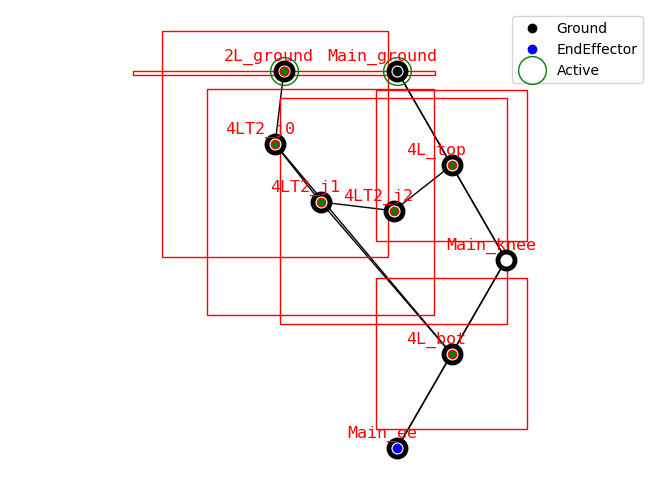

In [49]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[4]

actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

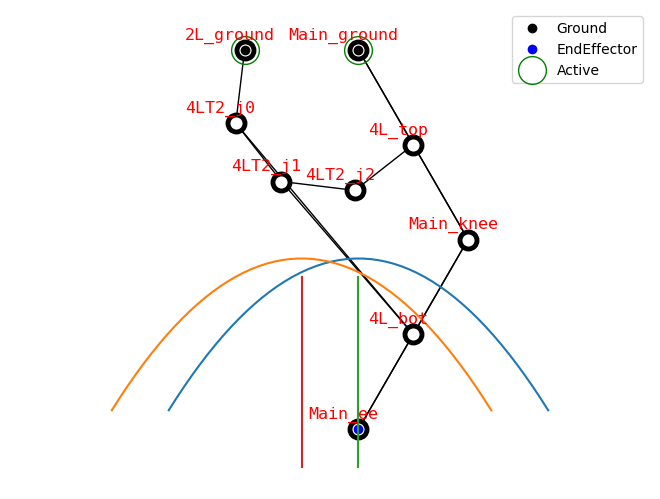

In [50]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.5, -0.95], step_height= 0.4, step_width=1,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.65, -0.95], step_height= 0.4, step_width=1,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.35, -0.95], step_height= 0.4, step_width=1,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, -0.15,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0.15,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1/20)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step, left_shift_step]
#step_trajectories = [ground_symmetric_step]


rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1/10)]



vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical, left_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]
#rewards_and_trajectories = [(rewards_vertical, vertical_trajectories)]

draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph to get normalizing values.

0 -0.236012568024113 [-0.236012568024113, 0]
1 -0.2574311141571891 [-0.2574311141571891, 0]
0 [-0.236012568024113, 0]
0 -0.10783987503667834 [-0.10783987503667834, 0]
1 -0.1570254278280403 [-0.1570254278280403, 0]
0 [-0.10783987503667834, 0]


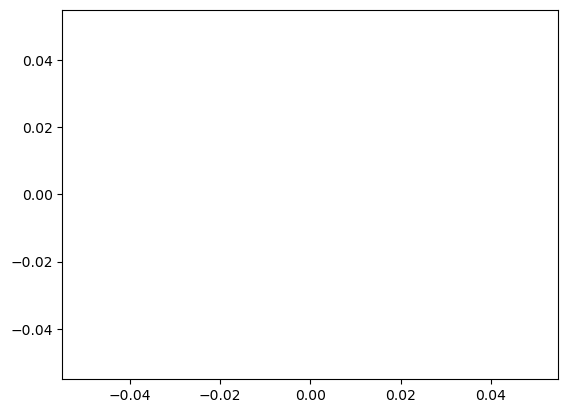

In [51]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id
        print(trajectory_id, current_total, current_partial)
    print(best_trajectory_id, max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
    plt.plot(reward_vector)
    # for i, partial_reward in enumerate(max_partial):
    #     if i != 0:
    #         rewards[i] = (rewards[i][0], 1/partial_reward)
            
    #         print(1/partial_reward)

In [52]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [53]:
population_size = 32
n_generations = 60

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

# best_id = np.argmin(optimizer.history["F"])
# best_x = optimizer.history["X"][best_id]
# best_reward = optimizer.history["F"][best_id]
# problem.mutate_JP_by_xopt(best_x)
# best_vector.append((problem.graph, j, best_reward))



     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  0.0940834705 | -3.491846E-01
     2 |       64 |  0.22027 |       3 |  0.5417 |  2.00000 |  2.01680 | -6.550124E-02 | -4.050856E-01
     3 |       96 |  0.08928 |       3 |  0.4568 |  1.99181 |  2.03304 | -1.846567E-01 | -8.609465E-01
     4 |      128 | -1.1E-02 |       3 |  0.3933 |  1.98000 |  2.05031 | -3.671042E-01 | -9.538131E-01
     5 |      160 | -2.3E-02 |       3 |  0.3855 |  1.96576 |  2.06077 | -5.161489E-01 | -1.168125E+00
     6 |      192 | -2.0E-02 |       3 |  0.3874 |  1.95378 |  2.07363 | -6.189694E-01 | -1.191162E+00
     7 |      224 |  0.01468 |       3 |  0.4092 |  1.94154 |  2.08313 | -7.072501E-01 | -1.276759E+00
     8 |      256 | -7.3E-03 |       3 |  0.3955 |  1.93063 |  2.08968 | -7.911565E-01 | -1.309335E+00
     9 |      288 | -1.3E-02 |       3 |  0.3920 |  1.92259 |  2.10430 | -8.563340E-01 | -1.321726E+00
    10 |      320 | -2.0E-03 |       3 |  0.3988 |  1.91159 |  2.11559 | 

In [54]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])

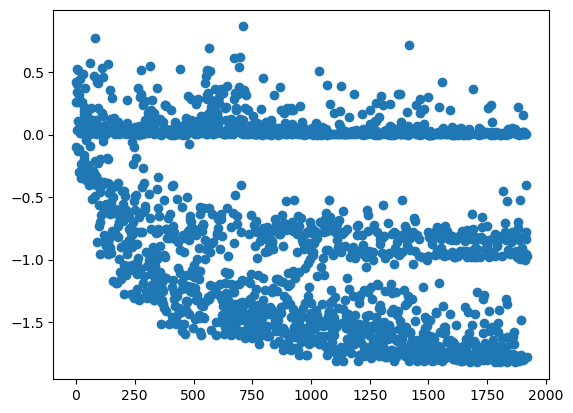

In [55]:
plt.scatter(np.arange(len(flatten_history)),flatten_history)

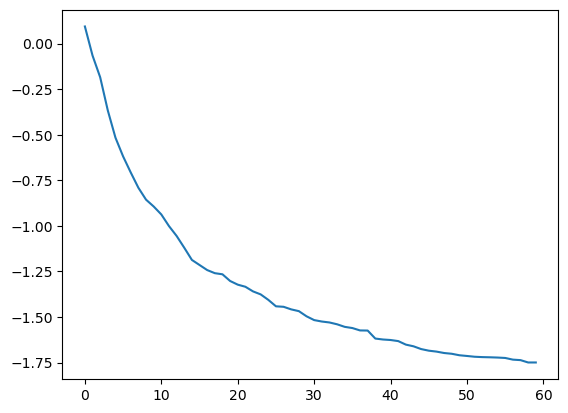

In [56]:
plt.plot(np.arange(len(history_mean)),history_mean)

In [57]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
worst_reward

array([0.86523103])

In [58]:
from auto_robot_design.optimization.visualizer import (
    prepare_data_to_visualize,
    draw_jps_cost_on_graph,
    prepare_data_to_visualize_separeate_jps,
    draw_jps_distribution,
    draw_costs,
    MARKERS,
)
features, costs, total_cost = prepare_data_to_visualize_separeate_jps(
    optimizer.history, problem
)

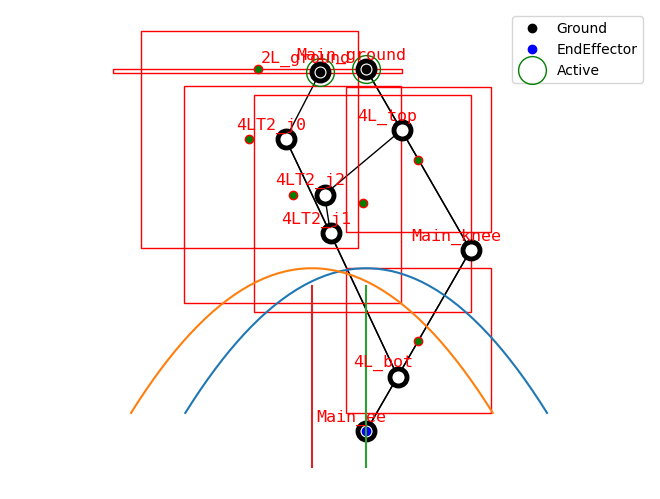

In [59]:
# best_x = optimizer.history["X"][best_id]
# problem.mutate_JP_by_xopt(best_x)
# draw_joint_point(problem.graph)


# plt.show()
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)
problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


# problem.mutate_JP_by_xopt(problem.initial_xopt)
# visualize_constrains(problem.graph, constrain_dict)
# draw_joint_point(problem.graph)

# for id, feat in enumerate(features):
#     plt.figure(figsize=(10, 10))
#     marker = MARKERS[id % len(MARKERS)]
#     # draw_jps_cost_on_graph(feat, costs[:, 0], problem, marker)
#     draw_jps_distribution(feat)
#     draw_joint_point(problem.graph)
#     plt.colorbar()
#     plt.axis("equal")
#     plt.show()

In [60]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward_decomposition = optimizer.history["Fs"][best_id]

best_reward_decomposition

array([[ 1.        ,  0.        , 16.8603799 ],
       [ 1.        ,  0.        ,  9.80114376]])

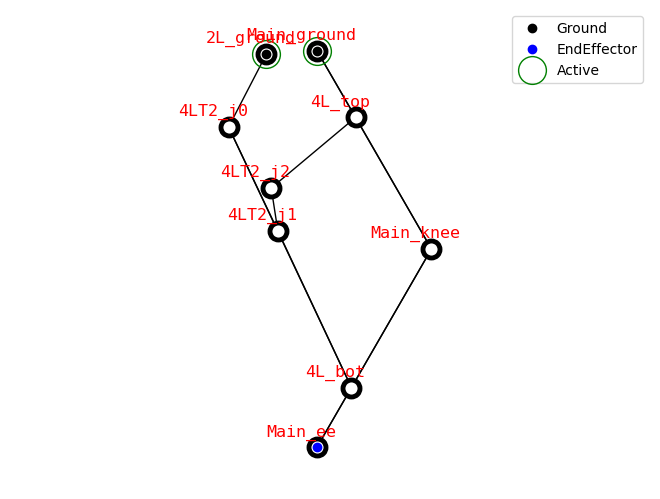

In [61]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward_decomposition = optimizer.history["Fs"][best_id]
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

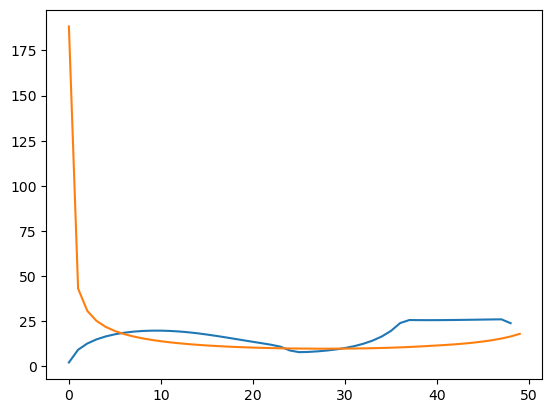

In [62]:
from auto_robot_design.description.builder import jps_graph2pinocchio_robot

fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
for i, reward_decomposition in enumerate(best_reward_decomposition):
    trajectory_id = int(reward_decomposition[0])
    trajectory = rewards_and_trajectories[i][1][trajectory_id]


    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards_and_trajectories[i][0][1][0]

    print(reward)
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
    plt.plot(reward_vector)
    reward_vector